# 02 Root Cause Analysis
Segment delay into seller processing and carrier transit components; rank top failing routes.


In [4]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ROOT = Path('..') if Path.cwd().name == 'notebooks' else Path('.')
if str(ROOT / 'src') not in sys.path:
    sys.path.append(str(ROOT / 'src'))

from utils import derive_delivery_features, rank_failure_routes

sns.set_theme(style='whitegrid')
processed_dir = ROOT / 'data' / 'processed'
fig_dir = ROOT / 'reports' / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)


In [5]:
parquet_path = processed_dir / 'order_delivery_legs.parquet'
csv_path = processed_dir / 'order_delivery_legs.csv'
legs = pd.read_parquet(parquet_path) if parquet_path.exists() else pd.read_csv(csv_path)

feat = derive_delivery_features(legs)
delivered = feat[feat['is_delivered']].copy()


In [6]:
cohort = delivered.groupby('is_late', as_index=False).agg(
    volume=('order_id', 'count'),
    mean_seller_processing=('seller_processing_days', 'mean'),
    median_seller_processing=('seller_processing_days', 'median'),
    p90_seller_processing=('seller_processing_days', lambda s: s.quantile(0.9)),
    mean_carrier_transit=('carrier_transit_days', 'mean'),
    median_carrier_transit=('carrier_transit_days', 'median'),
    p90_carrier_transit=('carrier_transit_days', lambda s: s.quantile(0.9)),
    mean_delay=('delay_days', 'mean'),
)
print('Late vs on-time component summary:')
print(cohort.round(3).to_string(index=False))

on_time = cohort[cohort['is_late'] == 0].iloc[0]
late = cohort[cohort['is_late'] == 1].iloc[0]
print('Uplift ratios:')
print('seller_processing_uplift:', round(late['mean_seller_processing'] / on_time['mean_seller_processing'], 3))
print('carrier_transit_uplift:', round(late['mean_carrier_transit'] / on_time['mean_carrier_transit'], 3))


Late vs on-time component summary:
 is_late  volume  mean_seller_processing  median_seller_processing  p90_seller_processing  mean_carrier_transit  median_carrier_transit  p90_carrier_transit  mean_delay
       0   89967                   2.987                     2.134                  6.068                 7.868                   6.914               15.060     -13.064
       1    7844                   5.830                     3.433                 13.766                25.673                  23.914               42.608       9.538
Uplift ratios:
seller_processing_uplift: 1.952
carrier_transit_uplift: 3.263


In [7]:
top_routes = rank_failure_routes(delivered, min_samples=100, top_n=5)
print('Top 5 failure routes:')
print(top_routes[['route','volume','failure_rate','mean_delay_days','mean_seller_processing_days','mean_carrier_transit_days']].round(4).to_string(index=False))

# Deterministic tie handling check
top_routes_check = rank_failure_routes(delivered, min_samples=100, top_n=5)
assert top_routes[['route','volume','failure_rate']].equals(top_routes_check[['route','volume','failure_rate']])
print('Deterministic ranking check passed.')


Top 5 failure routes:
 route  volume  failure_rate  mean_delay_days  mean_seller_processing_days  mean_carrier_transit_days
SP->AL     257        0.2607          -7.2749                       3.2950                    21.7049
MA->SP     124          0.25          -9.2423                       5.3449                    10.7481
SP->MA     497        0.2113          -8.6197                       3.5041                    18.5569
SP->PI     331        0.1813          -9.9423                       3.3684                    16.9370
PR->BA     144        0.1667          -9.5802                       4.1164                    17.7369
Deterministic ranking check passed.


In [8]:
route_table = delivered.groupby(['seller_state','customer_state'], as_index=False).agg(
    volume=('order_id','count'),
    failure_rate=('is_late','mean'),
    mean_delay=('delay_days','mean'),
    mean_seller=('seller_processing_days','mean'),
    mean_carrier=('carrier_transit_days','mean')
)
route_table = route_table[route_table['volume'] >= 100].copy()
route_table['seller_share_of_cycle'] = route_table['mean_seller'] / (route_table['mean_seller'] + route_table['mean_carrier'])
route_table['carrier_share_of_cycle'] = route_table['mean_carrier'] / (route_table['mean_seller'] + route_table['mean_carrier'])

print(route_table[['seller_state','customer_state','volume','failure_rate','seller_share_of_cycle','carrier_share_of_cycle']].head(10).round(3).to_string(index=False))


seller_state customer_state  volume  failure_rate  seller_share_of_cycle  carrier_share_of_cycle
          BA             SP     138         0.051                  0.268                   0.732
          DF             MG     103          0.01                  0.265                   0.735
          DF             SP     308         0.029                  0.282                   0.718
          ES             SP     100           0.1                  0.186                   0.814
          GO             SP     126          0.04                  0.238                   0.762
          MA             SP     124          0.25                  0.332                   0.668
          MG             BA     368         0.106                  0.167                   0.833
          MG             DF     190         0.032                  0.263                   0.737
          MG             ES     175         0.046                  0.242                   0.758
          MG             GO   

NaN count in top_routes_clean:
failure_rate    0
volume          0
dtype: int64

Data types:
failure_rate    Float64
volume            int64
dtype: object

First few rows:
    seller_state customer_state  volume  failure_rate  mean_delay_days  \
386           SP             AL     257        0.2607        -7.274866   
142           MA             SP     124          0.25        -9.242286   
394           SP             MA     497      0.211268        -8.619659   
401           SP             PI     331      0.181269        -9.942297   
257           PR             BA     144      0.166667        -9.580199   

     mean_seller_processing_days  mean_carrier_transit_days   route  
386                     3.294995                  21.704915  SP->AL  
142                     5.344898                  10.748134  MA->SP  
394                     3.504127                  18.556921  SP->MA  
401                     3.368367                  16.937010  SP->PI  
257                     4.116359 

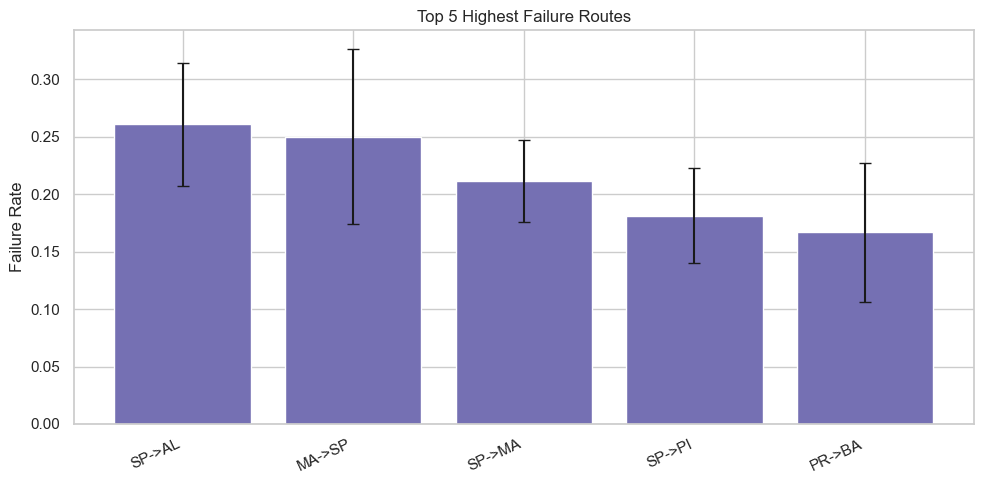

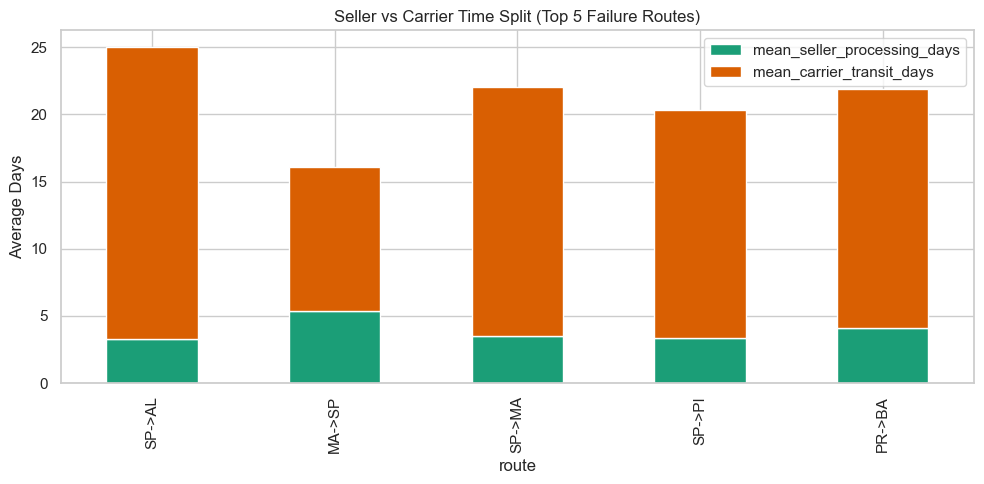

In [12]:
# Drop rows with NaN values in critical columns
route_table_clean = route_table.dropna(subset=['failure_rate'])
top_routes_clean = top_routes.dropna(subset=['failure_rate', 'volume'])

# Debug: Check for remaining NaN values
print("NaN count in top_routes_clean:")
print(top_routes_clean[['failure_rate', 'volume']].isna().sum())
print("\nData types:")
print(top_routes_clean[['failure_rate', 'volume']].dtypes)
print("\nFirst few rows:")
print(top_routes_clean.head())

# Heatmap
# pivot = route_table_clean.pivot(index='seller_state', columns='customer_state', values='failure_rate')
# plt.figure(figsize=(11, 7))
# sns.heatmap(pivot, cmap='Reds', linewidths=0.2)
# plt.title('Failure Rate Heatmap (volume >= 100)')
# plt.tight_layout()
# plt.savefig(fig_dir / '02_route_failure_heatmap.png', dpi=150)
# plt.show()

# Top 5 bars with 95% CI
plot_df = top_routes_clean.copy()
plot_df['ci95'] = 1.96 * np.sqrt((plot_df['failure_rate'] * (1 - plot_df['failure_rate'])) / plot_df['volume'])
plt.figure(figsize=(10, 5))
plt.bar(plot_df['route'], plot_df['failure_rate'], yerr=plot_df['ci95'], capsize=4, color='#7570b3')
plt.xticks(rotation=25, ha='right')
plt.ylabel('Failure Rate')
plt.title('Top 5 Highest Failure Routes')
plt.tight_layout()
plt.savefig(fig_dir / '02_top5_failure_routes.png', dpi=150)
plt.show()

# Seller vs carrier component split
comp = plot_df[['route','mean_seller_processing_days','mean_carrier_transit_days']].set_index('route')
comp.plot(kind='bar', stacked=True, figsize=(10, 5), color=['#1b9e77', '#d95f02'])
plt.ylabel('Average Days')
plt.title('Seller vs Carrier Time Split (Top 5 Failure Routes)')
plt.tight_layout()
plt.savefig(fig_dir / '02_component_split_top_routes.png', dpi=150)
plt.show()


Analysis is at order-seller leg grain, so multi-seller orders are represented by multiple route legs.
